# Medical Image Classification
In this practice, we will do chest X-ray classification for CheXpert data using a convolutional neural network.

**Task**: Binary classification; if edema (부종) is present (1) or not (0)

**Data**: CheXpert

**Model**: Convolutional neural network

**Framework**: Pytorch

## About dataset: CheXpert

* A large chest X-ray dataset and competition for automated chest X-ray interpretation.
* Total of 224,316 chest radiographs (from 65,240 patients) were provided by Stanford Hospital and clinics.
* Each radiograph was labeled for the presence of 14 observations as positive, negative, or uncertain.
* For more detail, visit here: https://stanfordmlgroup.github.io/competitions/chexpert/

<img src="images/CheXobs.png" width=400px>
<figcaption align = "left">image source: https://arxiv.org/abs/1901.07031</figcaption>

## Data preprocessing

For simple use, images and labels were preprocessed by TA.
* Replaced uncertain labels as positive labels. (https://arxiv.org/abs/1901.07031)
* Used single image per patient.
* Used only frontal images.
* Used 10% of training data as validation data.

## Import modules

In [1]:
import os
import csv
import time
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

from tqdm import tqdm
from PIL import Image
from pathlib import Path
import sklearn.metrics as metrics
from sklearn.metrics import roc_curve

import torch
import torch.optim as optim

from torch import nn
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import transforms as T

# pip install torchsummary
from torchsummary import summary
# pip install grad-cam
from pytorch_grad_cam import GradCAM 
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import BinaryClassifierOutputTarget

## Data paths and hyperparameters

In [2]:
IMG_PATH = "/media/leelabsg-storage1/DATA/CheXpert-v1.0-small"

# train: 58,079 (neg 43,741 / pos 14,338)
TRAIN_LABEL_PATH = "/media/leelabsg-storage1/wonyoung/coursework/GDA/practice6/train_practice6.csv"

# valid: 6,453 (neg 4,857 / pos 1,596)
VALID_LABEL_PATH = "/media/leelabsg-storage1/wonyoung/coursework/GDA/practice6/valid_practice6.csv"

# test: 200 (neg 158 / pos 42)
TEST_LABEL_PATH = "/media/leelabsg-storage1/wonyoung/coursework/GDA/practice6/test_practice6.csv"

# hyperparameters
IMAGE_SIZE = 320
BATCH_SIZE = 64
EPOCHS = 10
RESULTS_FOLDER = "./results_cls/"

## Define custom dataset class

In [3]:
class CXR_Cls_Dataset(Dataset):
    def __init__(self, image_path, label_path, image_size):
        super(CXR_Cls_Dataset, self).__init__()
        self.image_path = image_path
        self.mask_path = label_path
        
        image_names, labels = [], []

        with open(label_path, "r") as f:
            csv_reader = csv.reader(f)
            next(csv_reader, None) # skip the header
            for line in csv_reader:
                image_names.append(line[0]) # image path from base
                labels.append(float(line[10])) # Edema index

        self.image_names = image_names
        self.labels = labels

        self.transform = T.Compose([
            T.Resize((image_size, image_size)),
            T.ToTensor()
        ])

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, index):
        image_name = self.image_names[index]
        label = self.labels[index]

        image = Image.open(os.path.join(self.image_path, image_name)).convert("L")

        return self.transform(image), torch.tensor(label, dtype=torch.float32)

## Define dataset and dataloader

In [4]:
train_dataset = CXR_Cls_Dataset(IMG_PATH, TRAIN_LABEL_PATH, IMAGE_SIZE)
valid_dataset = CXR_Cls_Dataset(IMG_PATH, VALID_LABEL_PATH, IMAGE_SIZE)
test_dataset = CXR_Cls_Dataset(IMG_PATH, TEST_LABEL_PATH, IMAGE_SIZE)

print("Data Information")
print("    Train data:", len(train_dataset))
print("    Valid data:", len(valid_dataset))
print("    Test data:", len(test_dataset))

dataloader_train = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, 
                              shuffle=True, num_workers=4, pin_memory=True)
dataloader_valid = DataLoader(dataset=valid_dataset, batch_size=BATCH_SIZE, 
                              shuffle=False, num_workers=4, pin_memory=True)
dataloader_test = DataLoader(dataset=test_dataset, batch_size=1, 
                             shuffle=False, num_workers=4, pin_memory=True)

Data Information
    Train data: 58079
    Valid data: 6453
    Test data: 200


## Data sanity check

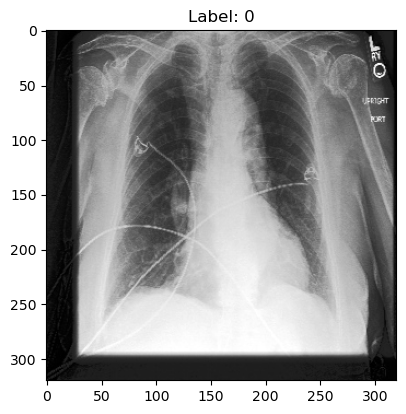

In [5]:
intput, target = next(iter(dataloader_train)) # dataloader_valid # dataloader_test
plt.figure(figsize=(25, 10))
for i in range(1):
    plt.subplot(2, 3, 1+i)
    plt.imshow(intput[i].reshape(IMAGE_SIZE, IMAGE_SIZE, 1), cmap="gray")
    plt.gca().set_title(f"Label: {int(target[i].numpy())}")
    plt.show()
plt.close()

# Define model class

In [6]:
# Fully customized CNN
class CNN(nn.Module):
    def __init__(self, in_channels):
        super(CNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=(3,3), stride=1, padding="same"),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=(2,2), stride=2),
            nn.Conv2d(32, 64, kernel_size=(3,3), stride=1, padding="same"),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=(2,2), stride=2),

            nn.Conv2d(64, 64, kernel_size=(3,3), stride=1, padding="same"),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=(2,2), stride=2),
            nn.Conv2d(64, 128, kernel_size=(3,3), stride=1, padding="same"),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=(2,2), stride=2),

            nn.Conv2d(128, 128, kernel_size=(3,3), stride=1, padding="same"),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=(2,2), stride=2),
            nn.Conv2d(128, 256, kernel_size=(3,3), stride=1, padding="same"),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size=(2,2), stride=2),
        )
        
        self.flatten = nn.Flatten()

        self.fc = nn.Sequential(
            nn.Linear(6400, 128), # 256x5x5
            nn.Dropout(0.2),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.flatten(x)
        x = self.fc(x)

        return x

In [ ]:
# Load ResNet50 and customize
class ResNet50(nn.Module):
    def __init__(self, out_features):
        super(ResNet50, self).__init__()
        self.resnet50 = torchvision.models.resnet50(weights=None)
        self.resnet50.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        num_ftrs = self.resnet50.fc.in_features
        self.resnet50.fc = nn.Sequential(
            nn.Linear(num_ftrs, out_features),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.resnet50(x)
        return x

<img src="images/resnet50.png" width=1000px>
<figcaption align = "left">image source: https://blog.devgenius.io/resnet50-6b42934db431</figcaption>

## Define model and optimizer

In [ ]:
#model = CNN(in_channels=1).cuda()
model = ResNet50(out_features=1).cuda()
#model = torch.nn.DataParallel(model).cuda() # use with multi-gpu environment
summary(model, input_size=(1, 320, 320), device="cuda")

optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=3,
                                                 verbose=1, eps=1e-04, cooldown=2, min_lr=1e-6)

## Define trainer

In [ ]:
class CXR_Cls_Trainer():
    def __init__(
            self, 
            model, 
            results_folder, 
            dataloader_train, 
            dataloader_valid, 
            dataloader_test, 
            epochs, 
            optimizer, 
            scheduler):
        super(CXR_Cls_Trainer, self).__init__()

        self.model = model
        self.dataloader_train = dataloader_train
        self.dataloader_valid = dataloader_valid
        self.dataloader_test = dataloader_test
        self.epoch = 0
        self.epochs = epochs
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.loss_fn = nn.BCELoss()

        self.results_folder = Path(results_folder)
        self.results_folder.mkdir(exist_ok=True)

    def train(self):
        print("[ Start training ]")
        self.model.train()
        valid_loss_min = 10000
        train_loss_list, valid_loss_list = [], []
        train_acc_list, valid_acc_list = [], []
        
        while self.epoch < self.epochs:
            print(f"\nEpoch {self.epoch+1:3d}: training")
            train_loss_sum, train_accurate_sum = 0, 0
            for batch_ID, (input, target) in enumerate(tqdm(self.dataloader_train)):
                input = input.cuda(non_blocking=True)
                target = target.reshape(-1, 1)
                target = target.cuda(non_blocking=True)
                
                output = self.model(input)

                loss = self.loss_fn(output, target)
                loss.backward()
                self.optimizer.step()
                self.optimizer.zero_grad()

                train_loss_sum += loss.item()*input.size(0)
                if batch_ID % 20 == 19:
                    print(f"\n[Batch: {batch_ID+1:5d}] training loss = {loss.item():.3f}", flush=True)

                train_accurate_sum += (output.cpu().round() == target.cpu()).sum()

            train_loss_avg = train_loss_sum / len(self.dataloader_train.dataset)
            train_acc_avg = train_accurate_sum / len(self.dataloader_train.dataset)

            train_loss_list.append(train_loss_avg)
            train_acc_list.append(train_acc_avg)

            # validation step
            print(f"\nEpoch {self.epoch+1:3d}: validation")
            self.model.eval()
            with torch.no_grad():
                valid_loss_sum, valid_accurate_sum = 0, 0
                for _, (input, target) in enumerate(tqdm(self.dataloader_valid)):
                    input = input.cuda(non_blocking=True)
                    target = target.reshape(-1, 1)
                    target = target.cuda(non_blocking=True)

                    output = self.model(input)

                    loss = self.loss_fn(output, target)

                    valid_loss_sum += loss.item()*input.size(0)
                    valid_accurate_sum += (output.cpu().round() == target.cpu()).sum()

                valid_loss_avg = valid_loss_sum / len(self.dataloader_valid.dataset)
                valid_acc_avg = valid_accurate_sum / len(self.dataloader_valid.dataset)

                valid_loss_list.append(valid_loss_avg)
                valid_acc_list.append(valid_acc_avg)
                self.scheduler.step(valid_loss_avg)
                print(f"    Epoch {self.epoch+1:2d}: training loss = {train_loss_avg:.3f} / validation loss = {valid_loss_avg:.3f}")
                print(f"    Epoch {self.epoch+1:2d}: training acc = {train_acc_avg:.3f} / validation acc = {valid_acc_avg:.3f}")

                # save model if better validation loss
                if valid_loss_sum < valid_loss_min:
                    valid_loss_min = valid_loss_sum
                    self.save(self.epoch+1)
                    print(f"    Saved model: cls-{self.epoch+1}.pth.tar")
                
            self.epoch += 1
        print("[ End training ]")
        return [train_loss_list, valid_loss_list], [train_acc_list, valid_acc_list]

    def test(self):
        print("[ Start test ]")
        self.model.eval()
        with torch.no_grad():
            test_loss_sum, test_accurate_sum = 0, 0
            output_array, target_array = np.array([]), np.array([])
            for _, (input, target) in enumerate(tqdm(self.dataloader_test)):
                input = input.cuda(non_blocking=True)
                target = target.reshape(-1, 1)
                target = target.cuda(non_blocking=True)
                
                output = self.model(input)

                output_array = np.append(output_array, output.cpu().numpy())
                target_array = np.append(target_array, target.cpu().numpy())

                loss = self.loss_fn(output, target)
                
                test_loss_sum += loss.item()*input.size(0)
                test_accurate_sum += (output.cpu().round() == target.cpu()).sum()

            test_loss_avg = test_loss_sum / len(self.dataloader_test.dataset)
            test_acc_avg = test_accurate_sum / len(self.dataloader_test.dataset)
            print(f"    test loss = {test_loss_avg:.3f} / test acc = {test_acc_avg:.3f}")

            # Draw ROC curve
            fpr, tpr, _ = roc_curve(target_array, output_array)
            roc_auc = metrics.auc(fpr, tpr)
            plt.plot(fpr, tpr) # ROC curve = TPR vs FPR
            plt.title(f"Receiver Operating Characteristics / AUC {roc_auc:.2f}")
            plt.xlabel("False Positive Rate")
            plt.ylabel("True Positive Rate")
            plt.show()
            plt.savefig(os.path.join(self.results_folder, "roc_plot.png"))
            plt.close()
            print(f"AUC: {roc_auc:.2f}")

        print("[ End test ]")
        self.output_array = output_array

    def save(self, milestone):
        files = os.listdir(self.results_folder)
        remove = [f for f in files if ".pth.tar" in f]
        if len(remove) > 0:
            os.remove(os.path.join(self.results_folder, remove[0]))
        torch.save({"epoch": milestone-1, 
                    "state_dict": self.model.state_dict(), 
                    "optimizer" : self.optimizer.state_dict()}, 
                    f"{self.results_folder}/cls-{milestone}.pth.tar")

    def load(self, milestone):
        checkpoint = torch.load(f"{self.results_folder}/cls-{milestone}.pth.tar")
        self.model.load_state_dict(checkpoint["state_dict"])
        self.optimizer.load_state_dict(checkpoint["optimizer"])
        self.epoch = checkpoint["epoch"]

    def GradCAM_func(self, num_images): # https://github.com/jacobgil/pytorch-grad-cam
        print("[ Start Grad-CAM ]")
        self.model.eval()
        target_layers = [self.model.resnet50.layer4[-1]]
        cam = GradCAM(model=self.model, target_layers=target_layers, use_cuda=True)
        image_list = self.get_images(num_images)

        for i, (input, target) in enumerate(self.dataloader_test):
            input = input.cuda(non_blocking=True)
            target = target.numpy()

            targets = [BinaryClassifierOutputTarget(target)]
            grayscale_cam = cam(input_tensor=input, targets=targets)
            grayscale_cam = grayscale_cam[0, :]
            visualization = show_cam_on_image(image_list[i], grayscale_cam, use_rgb=True)

            plt.imshow(visualization)
            plt.title(f"Label: {int(target)} / Pred: {self.output_array[i]:.2f}")
            plt.savefig(os.path.join(self.results_folder, f"grad-cam-{i+1}.png"))
            plt.close()
            if (i+1) == num_images: break
        print("[ End Grad-CAM ]")

    def get_images(self, num_images):
        image_list = []
        with open(TEST_LABEL_PATH, "r") as f:
            csv_reader = csv.reader(f)
            next(csv_reader, None) # skip the header
            for line in csv_reader:
                img = Image.open(os.path.join(IMG_PATH, line[0])).convert("L")
                img = img.resize((320, 320))
                img = np.array(img)
                img_norm = (img-np.min(img))/(np.max(img)-np.min(img))
                img_norm = np.expand_dims(img_norm, axis=2)
                image_list.append(img_norm)
                if len(image_list) == num_images: break

        return image_list

## Train the model

In [ ]:
# init the trainer
trainer = CXR_Cls_Trainer(model, 
                          RESULTS_FOLDER, 
                          dataloader_train, 
                          dataloader_valid, 
                          dataloader_test, 
                          EPOCHS, 
                          optimizer, 
                          scheduler)

In [ ]:
train_start = time.time()
loss_list, acc_list = trainer.train() # training!
train_end = time.time()
print(f"\nElapsed time: {(train_end - train_start) / 60:.0f} minutes")

In [ ]:
# Plot the training and validation loss and accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
ax1.plot(range(1, EPOCHS+1), loss_list[0], label="Training")
ax1.plot(range(1, EPOCHS+1), loss_list[1], label="Validation")
ax1.set_title("Training and Validation Loss")
ax1.legend()
ax2.plot(range(1, EPOCHS+1), acc_list[0], label="Training")
ax2.plot(range(1, EPOCHS+1), acc_list[1], label="Validation")
ax2.set_title("Training and Validation Accuracy")
ax2.legend()
plt.show()
plt.savefig(os.path.join(RESULTS_FOLDER, "loss_acc_plot.png"))
plt.close()

<img src="images/loss_acc_plot.png" width=600px>

# Test the model

In [ ]:
trainer.load(8)
trainer.test() # test the model

<img src="images/roc_plot.png" width=600px>

## Explainable AI for classification model

In [ ]:
trainer.GradCAM_func(num_images=16)

<img src="images/grad-cam-1.png" width=600px>

<img src="images/grad-cam-2.png" width=600px>

<img src="images/grad-cam-15.png" width=600px>

<img src="images/grad-cam-3.png" width=600px>